# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin

import sklearn.metrics as metrics

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random', min_eps=1e-4):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.min_eps = min_eps
        
    def randomize(self, choices):
        p = 0
        
        rand = np.random.uniform(0, sum(choices))
        
        for i in xrange(choices.shape[0]):
            if p + choices[i] >= rand:
                return i
            
            p += choices[i]
    
    def init_centroids(self, X):
        if self.init == 'random':
            for i in xrange(self.k):
                self.centroids[i] = X[np.random.randint(X.shape[0])]       
        else:
            self.centroids[0] = X[np.random.randint(X.shape[0])]
            
            for i in xrange(1, self.k):
                Y = metrics.pairwise_distances(self.centroids[:i], X, metric=self.metric)
                
                distances_min = np.min(Y, axis=0)
                
                self.centroids[i] = X[self.randomize(distances_min)]
                

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массивы с центроидами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        self.new_centroids = np.empty((self.k, X.shape[1]))
        
        self.init_centroids(X)
        
        eps = 1
        
        i = 0
        
        while (i < self.max_iter) and (eps > self.min_eps):
            i += 1
            
            Y = metrics.pairwise_distances(self.centroids, X, metric=self.metric)
            
            self.labels = np.argmin(Y, axis=0)
            
            for label in xrange(self.k):
                self.new_centroids[label] = sum(X[label == self.labels]) / len(X[label == self.labels])
                
            dist_centroids = metrics.pairwise_distances(self.centroids, self.new_centroids, metric=self.metric)
            
            self.centroids = self.new_centroids
            
            eps = max(dist_centroids.diagonal())
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        
        Y = metrics.pairwise_distances(self.centroids, X, metric=self.metric)
        
        return np.argmin(Y, axis=0)

    
class MiniBatchKMeans(Kmeans):
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random', min_eps=1e-4, batch_k=0.1):
        self.batch_k = batch_k
        
        Kmeans.__init__(self, k, metric, max_iter, random_state, init, min_eps)
        
    def fit(self, X, y=None):
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        batch_size = int(self.batch_k * X.shape[0])
        
        # Массив с метками кластеров для каждого объекта
        self.labels = np.empty(batch_size)
        
        # Массивы с центроидами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        self.new_centroids = np.empty((self.k, X.shape[1]))
        
        self.init_centroids(X)
        
        label_points = np.zeros(shape=(self.k))
        
        eps = 1
        
        i = 0
        
        while (i < self.max_iter) and (eps > self.min_eps):
            i += 1
            
            batch = X[np.random.randint(X.shape[0], size = batch_size)]
            
            Y = metrics.pairwise_distances(self.centroids, batch, metric=self.metric)

            self.labels = np.argmin(Y, axis=0)
            
            for j in xrange(batch_size):
                label = self.labels[j]
                
                label_points[label] += 1
                
                k = 1.0 / label_points[label]
                
                self.new_centroids[label] = k * batch[j] + (1 - k) * self.centroids[label]
                
            dist_centroids = metrics.pairwise_distances(self.centroids, self.new_centroids, metric=self.metric)
            
            self.centroids = self.new_centroids
            
            eps = max(dist_centroids.diagonal())
        
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

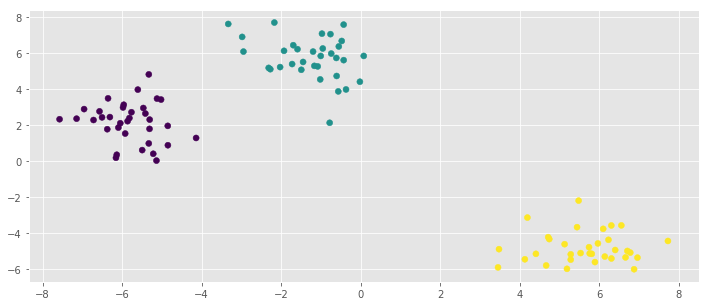

In [5]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

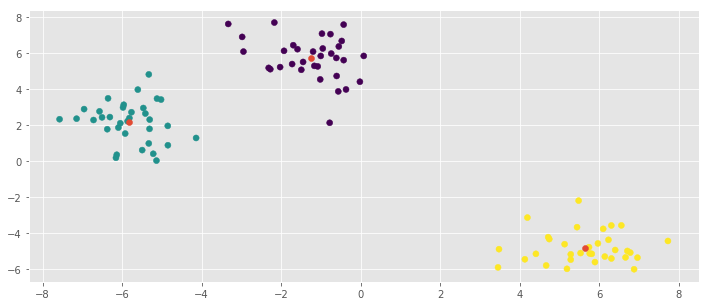

In [6]:
## Работоспособность KMeans
kmeans = Kmeans(k = 3, random_state=2)
kmeans.fit(X)

plt.scatter(X[:,0], X[:, 1], c=kmeans.predict(X))
plt.scatter(kmeans.centroids[:,0], kmeans.centroids[:,1])

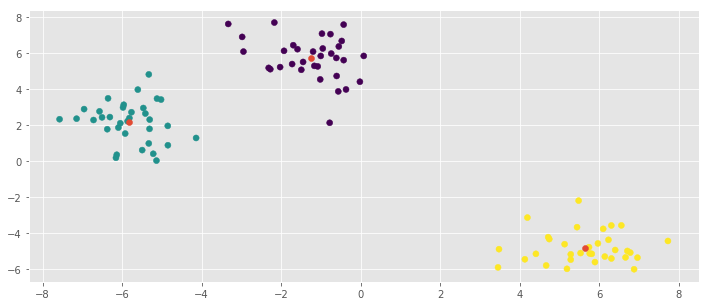

In [7]:
## Работоспособность KMeans++
kmeans_plus_plus = Kmeans(k = 3, init='k-means', random_state=2)
kmeans_plus_plus.fit(X)

plt.scatter(X[:,0], X[:, 1], c=kmeans_plus_plus.predict(X))
plt.scatter(kmeans_plus_plus.centroids[:,0], kmeans_plus_plus.centroids[:,1])

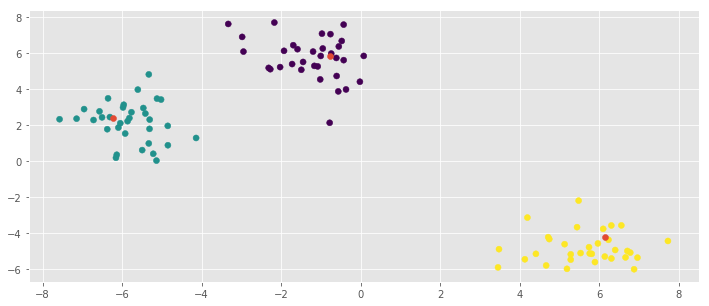

In [8]:
## Работоспособность KMeans с MiniBatchKMeans
kmeans_minibatch = MiniBatchKMeans(k = 3, random_state=2)
kmeans_minibatch.fit(X)

plt.scatter(X[:,0], X[:, 1], c=kmeans_minibatch.predict(X))
plt.scatter(kmeans_minibatch.centroids[:,0], kmeans_minibatch.centroids[:,1])

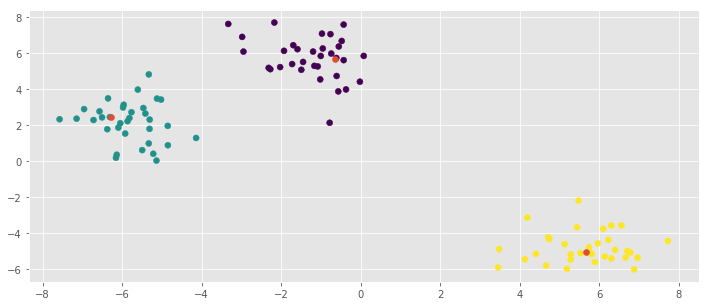

In [9]:
## Работоспособность KMeans++ с MiniBatchKMeans
kmeans_minibatch_plus_plus = MiniBatchKMeans(k = 3, init='k-means', random_state=2)
kmeans_minibatch_plus_plus.fit(X)

plt.scatter(X[:,0], X[:, 1], c=kmeans_minibatch_plus_plus.predict(X))
plt.scatter(kmeans_minibatch_plus_plus.centroids[:,0], kmeans_minibatch_plus_plus.centroids[:,1])

In [10]:
n_points = 20

t = np.empty(n_points)

step_samples = 50

min_samples = 50
max_samples = n_points * step_samples

100 loops, best of 3: 2.15 ms per loop
100 loops, best of 3: 3.05 ms per loop
100 loops, best of 3: 4 ms per loop
100 loops, best of 3: 3.71 ms per loop
100 loops, best of 3: 4.79 ms per loop
100 loops, best of 3: 4.29 ms per loop
100 loops, best of 3: 4.46 ms per loop
100 loops, best of 3: 5.09 ms per loop
100 loops, best of 3: 5.34 ms per loop
100 loops, best of 3: 5.26 ms per loop
100 loops, best of 3: 5.61 ms per loop
100 loops, best of 3: 5.89 ms per loop
100 loops, best of 3: 6.22 ms per loop
100 loops, best of 3: 6.61 ms per loop
100 loops, best of 3: 7.26 ms per loop
100 loops, best of 3: 7.16 ms per loop
100 loops, best of 3: 7.89 ms per loop
100 loops, best of 3: 7.84 ms per loop
100 loops, best of 3: 8.2 ms per loop
100 loops, best of 3: 8.65 ms per loop


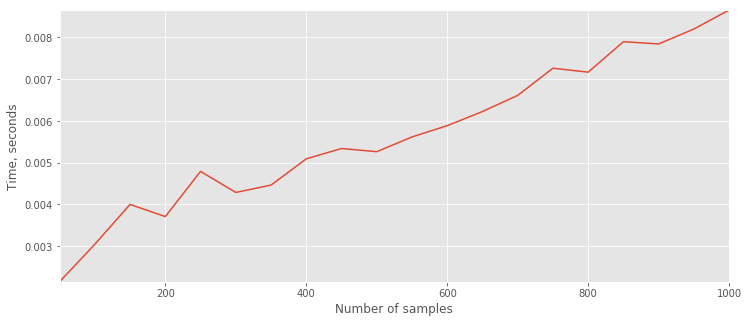

In [11]:
## Время выполнения алгоритма KMeans

kmeans = Kmeans(k=3, random_state=4)

for i in xrange(n_points):
    X, y = make_blobs(n_samples=(i+1)*step_samples, n_features=2, centers=3, cluster_std=1, 
                      center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    time = %timeit -o kmeans.fit(X)
   
    t[i] = time.best

plt.plot(np.arange(min_samples, max_samples+step_samples, step_samples), t)

plt.xlabel('Number of samples')
plt.ylabel('Time, seconds')

plt.axis([min_samples, max_samples, min(t), max(t)])

plt.show()

100 loops, best of 3: 3.21 ms per loop
100 loops, best of 3: 4.78 ms per loop
100 loops, best of 3: 4.2 ms per loop
100 loops, best of 3: 4.48 ms per loop
100 loops, best of 3: 5.26 ms per loop
100 loops, best of 3: 5.54 ms per loop
100 loops, best of 3: 5.98 ms per loop
100 loops, best of 3: 6.49 ms per loop
100 loops, best of 3: 8.14 ms per loop
100 loops, best of 3: 8.27 ms per loop
100 loops, best of 3: 9.6 ms per loop
100 loops, best of 3: 9.81 ms per loop
100 loops, best of 3: 10 ms per loop
100 loops, best of 3: 10.8 ms per loop
100 loops, best of 3: 11.6 ms per loop
100 loops, best of 3: 12.7 ms per loop
100 loops, best of 3: 13.4 ms per loop
100 loops, best of 3: 13.7 ms per loop
100 loops, best of 3: 13.3 ms per loop
100 loops, best of 3: 14.1 ms per loop


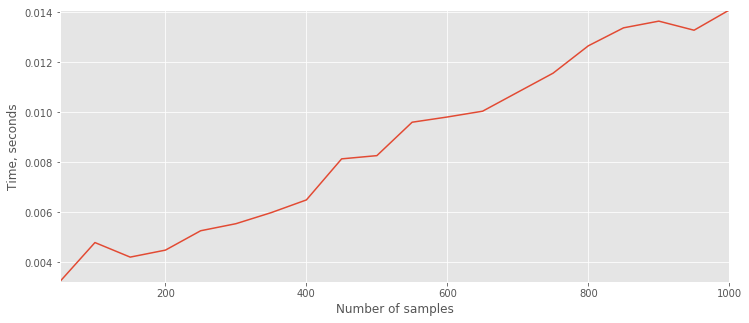

In [12]:
## Время выполнения алгоритма KMeans++

kmeans_plus_plus = Kmeans(k = 3, random_state=4, init='k-means')

for i in xrange(n_points):
    X, y = make_blobs(n_samples=(i + 1)*step_samples, n_features=2, centers=3, cluster_std=1, 
                      center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    time = %timeit -o kmeans_plus_plus.fit(X)
    
    t[i] = time.best

plt.plot(np.arange(min_samples, max_samples+step_samples, step_samples), t)

plt.xlabel('Number of samples')
plt.ylabel('Time, seconds')

plt.axis([min_samples, max_samples, min(t), max(t)])

plt.show()

100 loops, best of 3: 2.26 ms per loop
100 loops, best of 3: 2.5 ms per loop
100 loops, best of 3: 2.87 ms per loop
100 loops, best of 3: 3.25 ms per loop
100 loops, best of 3: 3.81 ms per loop
100 loops, best of 3: 3.98 ms per loop
100 loops, best of 3: 4.59 ms per loop
100 loops, best of 3: 4.84 ms per loop
100 loops, best of 3: 4.97 ms per loop
100 loops, best of 3: 5.41 ms per loop
100 loops, best of 3: 6.35 ms per loop
100 loops, best of 3: 7.07 ms per loop
100 loops, best of 3: 7.35 ms per loop
100 loops, best of 3: 7.6 ms per loop
100 loops, best of 3: 7.6 ms per loop
100 loops, best of 3: 8.4 ms per loop
100 loops, best of 3: 8.79 ms per loop
100 loops, best of 3: 9.82 ms per loop
100 loops, best of 3: 10.3 ms per loop
100 loops, best of 3: 10.7 ms per loop


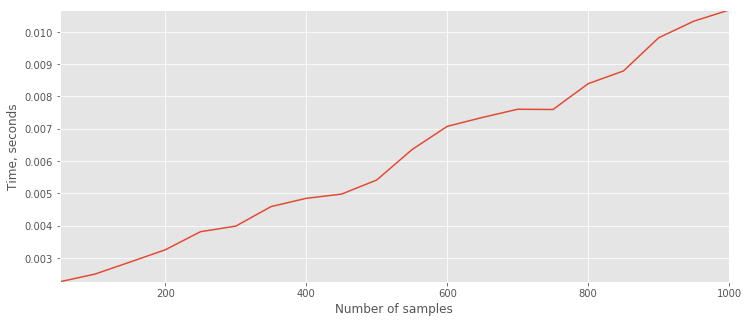

In [13]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans

kmeans_minibatch = Kmeans(k = 3, random_state=4)

for i in xrange(n_points):
    X, y = make_blobs(n_samples=(i+1)*step_samples, n_features=2, centers=3, cluster_std=1, 
                      center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    time = %timeit -o kmeans_minibatch.fit(X)
    
    t[i] = time.best

plt.plot(np.arange(min_samples, max_samples+step_samples, step_samples), t)

plt.xlabel('Number of samples')
plt.ylabel('Time, seconds')

plt.axis([min_samples, max_samples, min(t), max(t)])

plt.show()

100 loops, best of 3: 4.51 ms per loop
100 loops, best of 3: 5.04 ms per loop
100 loops, best of 3: 5.23 ms per loop
100 loops, best of 3: 5.67 ms per loop
100 loops, best of 3: 6.36 ms per loop
100 loops, best of 3: 7.52 ms per loop
100 loops, best of 3: 8.36 ms per loop
100 loops, best of 3: 8.42 ms per loop
100 loops, best of 3: 9.38 ms per loop
100 loops, best of 3: 9.69 ms per loop
100 loops, best of 3: 10.4 ms per loop
100 loops, best of 3: 10.5 ms per loop
100 loops, best of 3: 11.3 ms per loop
100 loops, best of 3: 11.9 ms per loop
100 loops, best of 3: 10.7 ms per loop
100 loops, best of 3: 11.1 ms per loop
100 loops, best of 3: 11.7 ms per loop
100 loops, best of 3: 12 ms per loop
100 loops, best of 3: 12.3 ms per loop
100 loops, best of 3: 12.9 ms per loop


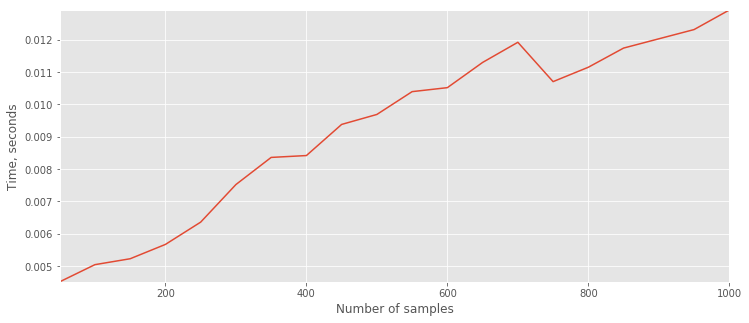

In [14]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans

kmeans_minibatch_plus_plus = Kmeans(k = 3, random_state=4, init='k-means')

for i in xrange(n_points):
    X, y = make_blobs(n_samples=(i + 1)*step_samples, n_features=2, centers=3, cluster_std=1, 
                      center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    time = %timeit -o kmeans_minibatch_plus_plus.fit(X)
    
    t[i] = time.best

plt.plot(np.arange(min_samples, max_samples+step_samples, step_samples), t)

plt.xlabel('Number of samples')
plt.ylabel('Time, seconds')

plt.axis([min_samples, max_samples, min(t), max(t)])

plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [15]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [16]:
df_sns_cutted = df_sns.iloc[:,4:]

df_sns_norm = (df_sns_cutted - df_sns_cutted.mean(axis=0)) / df_sns_cutted.std(axis=0)

X = df_sns_norm.as_matrix()

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

/home/alexfmsu/.local/lib/python2.7/site-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


Кластер: 0


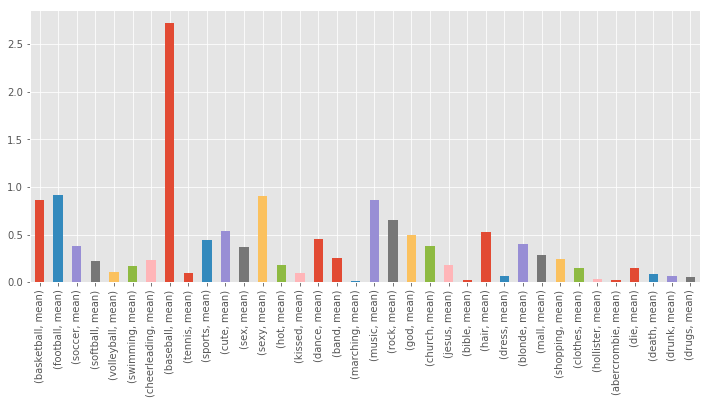

Кластер: 1


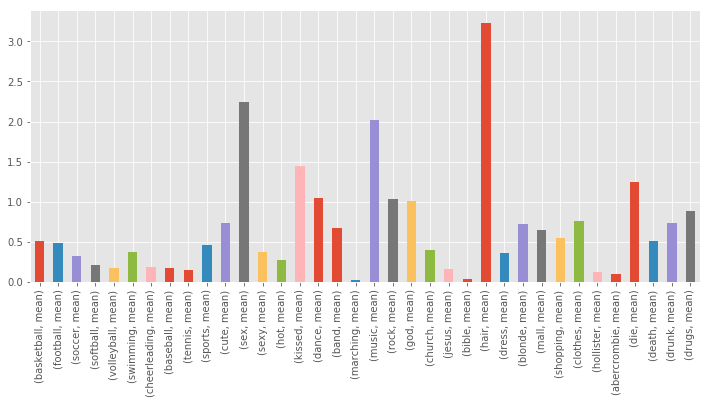

Кластер: 2


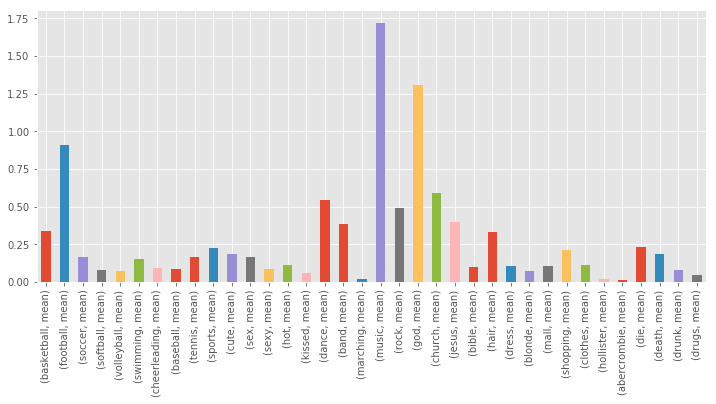

Кластер: 3


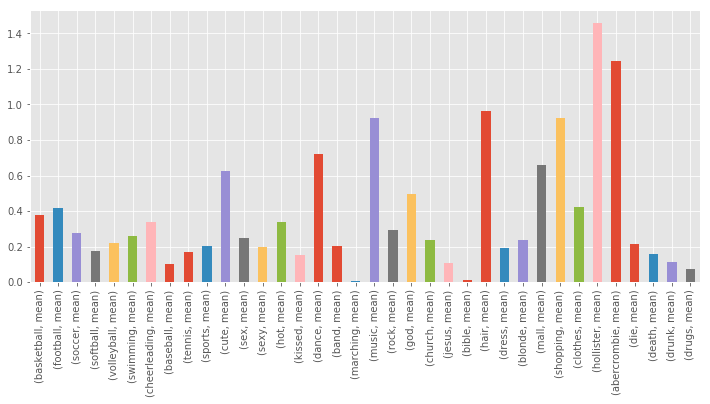

Кластер: 4


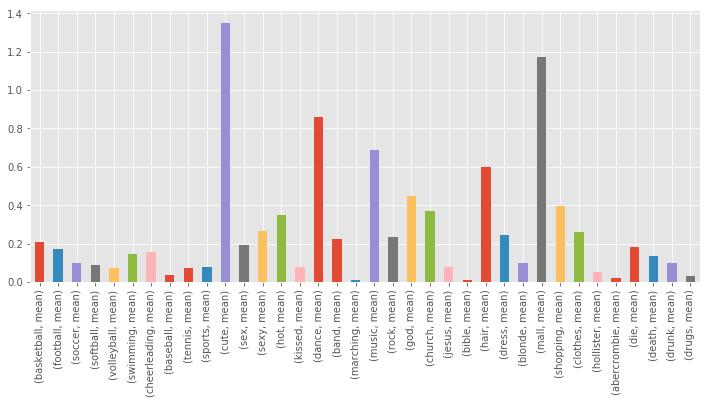

Кластер: 5


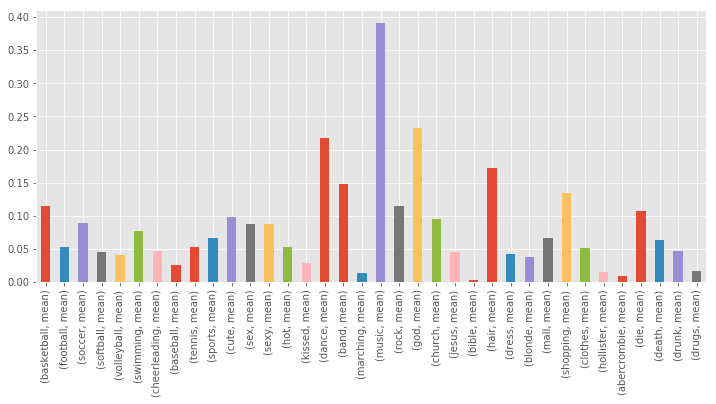

Кластер: 6


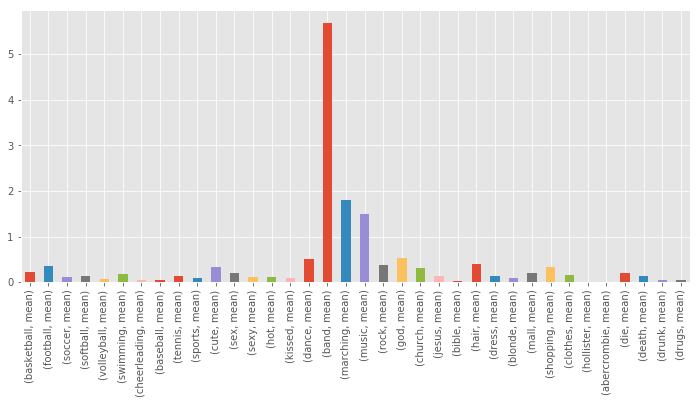

Кластер: 7


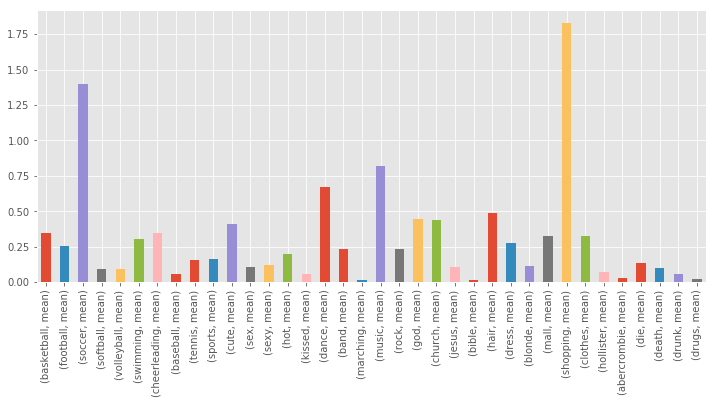

Кластер: 8


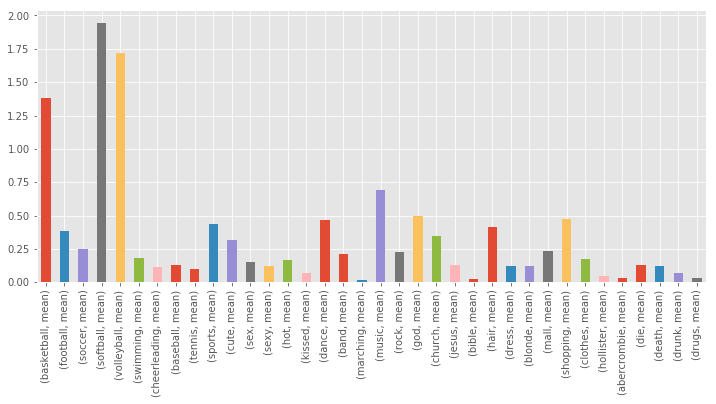

In [17]:
## KMeans
kmeans = Kmeans(k=9, random_state=4)
kmeans.fit(X)

df_sns.loc [:, 'Kmeans'] = kmeans.fit(X).predict(X)
df_sns.groupby('Kmeans') ['age'].aggregate (['count']).join (df_sns.groupby('Kmeans').aggregate (['mean']))

tb = df_sns.groupby('Kmeans') ['age'].aggregate (['count']).join (df_sns.groupby('Kmeans').aggregate (['mean']))

for i in xrange(0, 9):
    print "Кластер: {}".format(i)
    
    tb.iloc[i, 4:40].plot.bar()
    plt.show()

In [18]:
## KMeans++
kmeans_plus_plus = Kmeans(k = 9, random_state=4, init='k-means')

df_sns.loc [:, 'Kmeans'] = kmeans.fit(X).predict(X)
df_sns.groupby('Kmeans') ['age'].aggregate (['count']).join (df_sns.groupby('Kmeans').aggregate (['mean']))

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(blonde, mean)","(mall, mean)","(shopping, mean)","(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)"
Kmeans,,,,,,,,,,,,,,,,,,,,,
0,522,2007.759599,17.482153,34.173623,0.863105,0.919866,0.383973,0.223706,0.110184,0.165275,...,0.398998,0.282137,0.242070,0.146912,0.033389,0.018364,0.151920,0.090150,0.068447,0.050083
1,1013,2007.599831,17.711381,29.341794,0.514382,0.486464,0.323181,0.217428,0.181895,0.369712,...,0.725042,0.646362,0.552453,0.761421,0.131980,0.105753,1.249577,0.511844,0.739425,0.884941
2,3258,2007.463692,18.072157,32.637708,0.338527,0.907050,0.164510,0.081595,0.074465,0.151307,...,0.074993,0.109057,0.215738,0.114867,0.019012,0.013731,0.235807,0.189332,0.078426,0.048323
3,696,2007.874390,17.488204,41.565854,0.379268,0.419512,0.278049,0.173171,0.218293,0.260976,...,0.235366,0.657317,0.923171,0.423171,1.456098,1.243902,0.214634,0.158537,0.115854,0.075610
4,2629,2007.628118,17.670184,35.248137,0.207321,0.173307,0.100745,0.088111,0.072562,0.144801,...,0.098154,1.171688,0.398445,0.262715,0.052802,0.020732,0.183673,0.136054,0.101717,0.030450
5,13401,2007.413847,18.177925,26.393149,0.114204,0.053683,0.089148,0.045633,0.041699,0.076863,...,0.038613,0.066090,0.134056,0.051928,0.015675,0.008897,0.106700,0.063487,0.046481,0.017430
6,384,2007.357143,18.217211,31.928571,0.211982,0.352535,0.117512,0.129032,0.073733,0.182028,...,0.089862,0.209677,0.343318,0.154378,0.011521,0.013825,0.191244,0.142857,0.057604,0.043779
7,1836,2007.613825,17.710186,36.304147,0.347005,0.252535,1.400461,0.091244,0.095853,0.303687,...,0.115207,0.324424,1.825806,0.326267,0.074654,0.032258,0.134562,0.102765,0.058065,0.023041
8,1175,2007.786123,17.544231,39.346924,1.380544,0.386981,0.247496,1.941345,1.716023,0.181688,...,0.118026,0.237482,0.473534,0.172389,0.046495,0.028612,0.129471,0.119456,0.070815,0.029328


In [19]:
## KMeans с MiniBatchKMeans
kmeans_minibatch = MiniBatchKMeans(k = 9, random_state=4)

df_sns.loc [:, 'Kmeans'] = kmeans_minibatch.fit(X).predict(X)
df_sns.groupby('Kmeans') ['age'].aggregate (['count']).join (df_sns.groupby('Kmeans').aggregate (['mean']))

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(blonde, mean)","(mall, mean)","(shopping, mean)","(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)"
Kmeans,,,,,,,,,,,,,,,,,,,,,
0,667,2007.748387,17.501471,34.561290,0.716129,0.752258,0.356129,0.203871,0.100645,0.126452,...,0.331613,0.238710,0.261935,0.178065,0.056774,0.033548,0.169032,0.121290,0.121290,0.051613
1,1170,2007.630848,17.944247,30.695906,0.393275,0.407895,0.281433,0.168129,0.157895,0.802632,...,0.685673,0.711257,0.515351,0.617690,0.138158,0.071637,1.264620,0.417398,0.496345,0.588450
2,3457,2007.434141,17.995301,31.746313,0.249938,0.936766,0.195451,0.065234,0.055236,0.117221,...,0.059985,0.089228,0.203449,0.110972,0.030992,0.014246,0.187203,0.148213,0.093227,0.057236
3,506,2007.794915,17.921723,42.340678,0.413559,0.403390,0.311864,0.152542,0.215254,0.235593,...,0.301695,0.576271,0.862712,0.472881,1.264407,1.481356,0.315254,0.203390,0.176271,0.232203
4,3379,2007.592509,17.670299,34.152086,0.157114,0.129462,0.114128,0.074409,0.054801,0.114379,...,0.073906,1.048768,0.333585,0.203369,0.067622,0.029663,0.156863,0.128457,0.102061,0.037707
5,11900,2007.408381,18.195745,26.030754,0.088205,0.044204,0.098885,0.034133,0.027847,0.059682,...,0.039878,0.025482,0.121190,0.056911,0.021561,0.011085,0.100034,0.067996,0.045691,0.018925
6,361,2007.382353,18.243277,32.107843,0.191176,0.352941,0.132353,0.142157,0.080882,0.178922,...,0.080882,0.237745,0.367647,0.156863,0.014706,0.014706,0.183824,0.144608,0.071078,0.044118
7,1801,2007.621876,17.751096,36.301744,0.502122,0.238095,1.248468,0.074965,0.070250,0.235266,...,0.111268,0.384724,1.966054,0.332862,0.127298,0.054220,0.136256,0.115512,0.065064,0.034889
8,1673,2007.752037,17.670057,37.439409,1.328921,0.317719,0.222505,1.567719,1.446029,0.161914,...,0.102851,0.205703,0.467923,0.167006,0.065682,0.039206,0.131874,0.116090,0.071283,0.040733


In [20]:
## KMeans++ с MiniBatchKMeans
kmeans_minibatch_plus_plus = MiniBatchKMeans(k = 9, random_state=4, init='k-means')

df_sns.loc [:, 'Kmeans'] = kmeans_minibatch_plus_plus.fit(X).predict(X)
df_sns.groupby('Kmeans') ['age'].aggregate (['count']).join (df_sns.groupby('Kmeans').aggregate (['mean']))

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(blonde, mean)","(mall, mean)","(shopping, mean)","(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)"
Kmeans,,,,,,,,,,,,,,,,,,,,,
0,511,2007.725888,17.419162,34.194585,0.822335,0.888325,0.301184,0.429780,0.225042,0.221658,...,0.368866,0.245347,0.306261,0.138748,0.084602,0.064298,0.199662,0.096447,0.113367,0.077834
1,2088,2007.743977,17.413535,37.866068,0.995917,0.468763,0.187832,0.335239,0.307472,0.242956,...,0.173949,1.708044,0.751735,0.164149,0.216007,0.155165,0.267864,0.104532,0.147407,0.156390
2,368,2007.396313,17.625334,32.419355,0.244240,0.264977,0.117512,0.175115,0.124424,0.124424,...,0.896313,0.350230,0.382488,0.232719,0.092166,0.092166,0.907834,2.587558,0.271889,0.221198
3,347,2007.797101,17.613937,35.152174,0.599034,0.541063,5.980676,0.200483,0.224638,0.195652,...,0.205314,0.277778,0.586957,0.164251,0.108696,0.079710,0.234300,0.123188,0.123188,0.120773
4,3697,2007.504525,18.104453,30.204920,0.239963,0.934324,0.162683,0.177071,0.157113,0.132745,...,0.052448,0.068926,0.251799,0.035043,0.032722,0.025528,0.158970,0.072407,0.066373,0.035275
5,1880,2007.589996,17.854245,33.918267,0.172845,0.145601,0.138901,0.143368,0.144261,0.114337,...,0.107637,0.188924,0.363109,0.107637,0.080840,0.059402,0.177758,0.076820,0.125949,0.066101
6,12900,2007.418859,18.198046,27.387700,0.115385,0.016493,0.113811,0.103047,0.094108,0.098137,...,0.044882,0.078245,0.235553,0.008624,0.034307,0.024361,0.127156,0.060305,0.051933,0.022347
7,1658,2007.632397,17.534024,31.984453,0.247743,0.206620,0.158475,0.200100,0.191575,0.228185,...,0.126881,0.296389,0.728686,1.435306,0.173019,0.109328,0.237713,0.115848,0.130893,0.104814
8,1465,2007.497031,17.828055,34.954869,0.589667,0.315321,0.226841,0.286223,0.228029,0.195368,...,0.247625,0.339667,0.633017,0.244062,0.130641,0.116390,0.404394,0.158551,0.230404,0.222090


### Интерпретация кластеров:
<p><br/>
<b>Кластер 0</b>: любят спорт - бейсбол, футбол, баскетбол (baseball, football, basketball)
<p>
<b>Кластер 1</b>: следят за внешностью, любят музыку; общительны (hair, music, sex)
<p>
<b>Кластер 2</b>: любят музыку, футбол; религиозны (music, football, god, church)
<p>
<b>Кластер 3</b>: следят за внешностью (abercrombie)
<p>
<b>Кластер 4</b>: обыватели; увлекаются музыкой, танцами (cute, mall, music, dance)
<p>
<b>Кластер 5</b>: увлекаются музыкой, танцами; религиозны (music, dance, god)
<p>
<b>Кластер 6</b>: общительные (band)
<p>
<b>Кластер 7</b>: увлекаются футболом, шопингом (soccer, shopping)    
<p>
<b>Кластер 8</b>: любят спор - софтбол, волейбол, баскетбол (softball, volleyball, basketball)


### Вывод

Kmeans: случайно выбранные центры кластеров могут оказаться слишком близко друг к другу, что может привести к неверной кластеризации

MiniBatch: выигрыш во времени, но при этом падает точность

KMeans++: время кластеризации значительно растет по мере увеличения числа точек; безопасный выбор центров кластеров (в отличие от Kmeans)